# Deep Learning Tutorial 04: CNN - Object Recognition with CIFAR-10 (Ch21)

from Deep Learning with Python by Jason Brownlee (2016)
[e-book](https://machinelearningmastery.com/deep-learning-with-python/)
[요약](http://machinelearningmastery.com/introduction-python-deep-learning-library-keras/)

# Chapter 21 Project Object Recognition in Photographs

## 21.1 Photograph Object Recognition Dataset

[CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html)  
- 60,000 photos, 10 classes
- training: 50,000
- test: 10,000
- rgb
- 32x32

[Classification Results](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)

## 21.2 Loading The CIFAR-10 Dataset in Keras

** 주의 : scipy.misc.toimage 는 pil 패키지가 설치되어 있어야 실행됨 **

Using Theano backend.


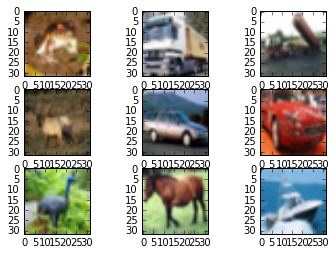

In [1]:
%matplotlib inline

# Plot ad hoc CIFAR10 instances
from keras.datasets import cifar10
from matplotlib import pyplot
from scipy.misc import toimage
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# create a grid of 3x3 images
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(toimage(X_train[i]))
# show the plot
pyplot.show()

In [2]:
!ls -al ~/.keras/datasets

total 181460
drwxrwxr-x 3 kikim kikim      4096  7월 24 23:17 .
drwxrwxr-x 3 kikim kikim      4096  7월  7 16:35 ..
drwxr-xr-x 2 kikim kikim      4096  6월  5  2009 cifar-10-batches-py
-rw-rw-r-- 1 kikim kikim 170498071  7월 24 23:17 cifar-10-batches-py.tar.gz
-rw-rw-r-- 1 kikim kikim  15296311  7월  7 16:35 mnist.pkl.gz


## 21.3 Simple CNN for CIFAR-10

In [3]:
# Simple CNN model for CIFAR-10
import numpy
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

print('before one-hot-encode: y_train[0, :]=', y_train[0, :])

('before one-hot-encode: y_train[0, :]=', array([6], dtype=uint8))


In [4]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

print('after one-hot-encode: y_train[0, :]=', y_train[0, :])

('after one-hot-encode: y_train[0, :]=', array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]))


<img src="files/imgs/Fig21_2.png" />

In [5]:
# Create the baseline model
def buildBaselineModel():
    model = Sequential()
    model.add(Convolution2D(32, 3, 3, input_shape=(3, 32, 32), 
                            border_mode='same', activation='relu', 
                            W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(32, 3, 3, activation='relu', 
                            border_mode='same', W_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [6]:
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

model = buildBaselineModel()
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 32, 32)    896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 32, 32, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 32, 32)    9248        dropout_1[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 16, 16)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [ ]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          nb_epoch=epochs, batch_size=32, verbose=2)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Accuracy: %.2f%%" % (scores[1] * 100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
182s - loss: 1.7392 - acc: 0.3735 - val_loss: 1.5593 - val_acc: 0.4489
Epoch 2/25
178s - loss: 1.3701 - acc: 0.5043 - val_loss: 1.2491 - val_acc: 0.5462
Epoch 3/25
189s - loss: 1.2156 - acc: 0.5638 - val_loss: 1.1421 - val_acc: 0.5987
Epoch 4/25
187s - loss: 1.1064 - acc: 0.6048 - val_loss: 1.0731 - val_acc: 0.6186
Epoch 5/25
188s - loss: 1.0186 - acc: 0.6374 - val_loss: 1.0326 - val_acc: 0.6329
Epoch 6/25


In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("./models/cnn-cifar10-baseline.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("./models/cnn-cifar10-baseline.h5")
print("Saved model to disk")

In [1]:
!ls -al ./models

total 16476
drwxrwxr-x 2 kikim kikim     4096  7월 25 00:43 .
drwxrwxr-x 6 kikim kikim     4096  7월 25 10:01 ..
-rw-rw-r-- 1 kikim kikim 16855240  7월 25 00:43 cnn-cifar10-baseline.h5
-rw-rw-r-- 1 kikim kikim     2228  7월 25 00:43 cnn-cifar10-baseline.json


## 21.4 Larger CNN for CIFAR-10

In [25]:
# Create the Larger model
def buildLargerModel():
    model = Sequential()
    model.add(Convolution2D(32, 3, 3, input_shape=(3, 32, 32), activation='relu', border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
    model.add(Dropout(0.2))
    model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

model = buildLargerModel()
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_8 (Convolution2D)  (None, 32, 32, 32)    896         convolution2d_input_5[0][0]      
____________________________________________________________________________________________________
dropout_7 (Dropout)              (None, 32, 32, 32)    0           convolution2d_8[0][0]            
____________________________________________________________________________________________________
convolution2d_9 (Convolution2D)  (None, 32, 32, 32)    9248        dropout_7[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_4 (MaxPooling2D)    (None, 32, 16, 16)    0           convolution2d_9[0][0]            
___________________________________________________________________________________________

In [26]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=epochs,
batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("LargerModel Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 11s - loss: 1.9125 - acc: 0.2911 - val_loss: 1.5976 - val_acc: 0.4215
Epoch 2/25
50000/50000 [==============================] - 11s - loss: 1.4983 - acc: 0.4518 - val_loss: 1.3104 - val_acc: 0.5176
Epoch 3/25
50000/50000 [==============================] - 11s - loss: 1.3150 - acc: 0.5232 - val_loss: 1.2134 - val_acc: 0.5670
Epoch 4/25
50000/50000 [==============================] - 11s - loss: 1.1841 - acc: 0.5748 - val_loss: 1.1052 - val_acc: 0.5987
Epoch 5/25
50000/50000 [==============================] - 11s - loss: 1.0845 - acc: 0.6111 - val_loss: 1.0470 - val_acc: 0.6267
Epoch 6/25
50000/50000 [==============================] - 11s - loss: 0.9939 - acc: 0.6444 - val_loss: 0.9344 - val_acc: 0.6652
Epoch 7/25
50000/50000 [==============================] - 11s - loss: 0.9171 - acc: 0.6753 - val_loss: 0.8765 - val_acc: 0.6963
Epoch 8/25
50000/50000 [==============================

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("./models/cnn-cifar10-large.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("./models/cnn-cifar10-large.h5")
print("Saved model to disk")

## 학습된 모델 확인
학습된 모델이 테스트 데이터의 클래스를 뭐라고 예측해보는지 직접 확인해보자.
[Keras - The Sequential model API](http://keras.io/models/sequential/)의 predict()와 predict_classes()로 실행할 수 있다.

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os

# load model
# load json and create model
json_file = open('./models/cnn-cifar10-baseline.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights("./models/cnn-cifar10-baseline.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Loaded model from disk


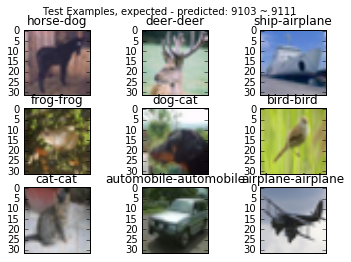

In [15]:
%matplotlib inline

from keras.datasets import cifar10
from matplotlib import pyplot
from scipy.misc import toimage
from numpy import random

# load data
(ori_X_train, ori_y_train), (ori_X_test, ori_y_test) = cifar10.load_data()

classNames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
              'dog', 'frog', 'horse', 'ship', 'truck']

# normalize inputs from 0-255 to 0.0-1.0
X_test = ori_X_test.astype('float32')
X_test = X_test / 255.0

# get random test example index to predict
rIdx = int(random.rand()*9990)

# predict some test examples
pred_Y_test = model.predict_classes(X_test[rIdx:rIdx+9], batch_size=32, verbose=2)

# show example images and expected-precdicted classes
fig = pyplot.figure()
fig.suptitle(u"Test Examples, expected - predicted: %d ~ %d\n  " % (rIdx, rIdx + 8))
for i in range(0, 9):
    ax = fig.add_subplot(330 + 1 + i)
    ax.imshow(toimage(ori_X_test[rIdx+i]))
    ax.set_title(u'%s-%s' % (classNames[ori_y_test[rIdx+i,0]], classNames[pred_Y_test[i]]))
    ax.set_xticks([])
# show the plot
pyplot.show()